In [235]:
# Load các thư viện cần thiết
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import lightgbm as lgb

# I. Cấu hình

In [236]:
# Cấu hình các tham số của Model
SEED = 1010
LGBM_PARAMS = {
    'num_leaves': 300, # Số lá tối đa
    'max_bin':450, #Số bin tối đa
    'objective': 'binary', # Loại mô hình (binary: hồi quy logistic)
    'learning_rate': 0.01, # Tỉ lệ học
    'boosting_type': 'gbdt',  
    'random_state': 1010, # Tạo seed random
    'metric':"binary_logloss",
    'verbosity':-1
}
LGBM_FIT_PARAMS = {
    'num_boost_round': 10000, # Số vòng thực hiện tăng cường
    'early_stopping_rounds': 50, # Số lần mà nếu valid_score ngưng cải thiện thì sẽ dừng sớm 
    'verbose_eval': 100, # In ra đánh giá sau verbose_eval lần
}

## 1. Hàm hàm huấn luyện LightGBM

In [237]:

def train_lgbm(X_train, Y_train, X_valid, Y_valid, X_test, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):

    train = lgb.Dataset(X_train, Y_train,)

    if X_valid is not None: 
        valid = lgb.Dataset(X_valid, Y_valid)
        model = lgb.train(lgb_params, train,
                          valid_sets=[train,valid], **fit_params)
        Y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(Y_valid, Y_pred_valid)
    else:
        model = lgb.train(lgb_params, train,
                          **fit_params)
        Y_pred_valid = None
        valid_loss = None

    if X_test is not None:
        Y_pred_test = model.predict(X_test) 
    else:
        Y_pred_test = None

    if calc_importances:
        importances = pd.DataFrame()
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return Y_pred_valid, Y_pred_test, valid_loss, importances, model.best_iteration, model

## 2. Hàm thiết lập đầu vào

In [238]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "Score1", 
        "LTeamID" : "TeamIdB",
        "LScore": "Score2",
        'FGMW':'FGMA', 
        'FGAW':'FGAA', 
        'FGM3W':'FGM3A',
        'FGA3W':'FGA3A',
        'FTMW':'FTMA', 
        'FTAW':'FTAA', 
        'ORW':'ORA', 
        'DRW':'DRA',
        'AstW':'AstA',
        'TOW':'TOA',
        'StlW':'StlA',
        'BlkW':'BlkA',
        'PFW':'PFA',
        'FG%W':'FG%A',
        '3P%W':'3P%A',
        'FT%W':'FT%A',
        'eFG%W':'eFG%A',
        'TOV%W':'TOV%A',
        'FreeThrowsW':'FreeThrowsA',
        'POSSW':'POSSA',
        'PPPW':'PPPA',
        'TS%W':'TS%A',
        'EVW':'EVA',
        'TRW':'TRA',
        'OR%W':'OR%A',
        'ScoreW':'ScoreA',
        'ScoredW':'ScoredA',
        'ScoregapW':'ScoregapA',
        'NumWinsW': 'NumWinsA', 
        'NumLosesW':'NumLosesA', 
        'WinRatioW':'WinRatioA',
        'RatingW': 'RatingA',
        'FGML':'FGMB',
        'FGAL':'FGAB', 
        'FGM3L':'FGM3B',
        'FGA3L':'FGA3B',
        'FTML':'FTMB', 
        'FTAL':'FTAB', 
        'ORL':'ORB',
        'DRL':'DRB',
        'AstL':'AstB',
        'TOL':'TOB',
        'StlL':'StlB',
        'BlkL':'BlkB',
        'PFL':'PFB',
        'FG%L':'FG%B',
        '3P%L':'3P%B',
        'FT%L':'FT%B',
        'eFG%L':'eFG%B',
        'TOV%L':'TOV%B',
        'FreeThrowsL':'FreeThrowsB',
        'POSSL':'POSSB',
        'PPPL':'PPPB',
        'TS%L':'TS%B',
        'EVL':'EVB',
        'TRL':'TRB',
        'OR%L':'OR%B',
        'ScoreL':'ScoreB',
        'ScoredL':'ScoredB',
        'ScoregapL':'ScoregapB',
        'NumWinsL': 'NumWinsB',
        'NumLosesL':'NumLosesB', 
        'WinRatioL':'WinRatioB',
        'RatingL': 'RatingB',
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "Score2", 
        "LTeamID" : "TeamIdA",
        "LScore": "Score1",
        'FGMW':'FGMB', 
        'FGAW':'FGAB', 
        'FGM3W':'FGM3B',
        'FGA3W':'FGA3B',
        'FTMW':'FTMB', 
        'FTAW':'FTAB', 
        'ORW':'ORB', 
        'DRW':'DRB',
        'AstW':'AstB',
        'TOW':'TOB',
        'StlW':'StlB',
        'BlkW':'BlkB',
        'PFW':'PFB',
        'FG%W':'FG%B',
        '3P%W':'3P%B',
        'FT%W':'FT%B',
        'eFG%W':'eFG%B',
        'TOV%W':'TOV%B',
        'FreeThrowsW':'FreeThrowsB',
        'POSSW':'POSSB',
        'PPPW':'PPPB',
        'TS%W':'TS%B',
        'EVW':'EVB',
        'TRW':'TRB',
        'OR%W':'OR%B',
        'ScoreW':'ScoreB',
        'ScoredW':'ScoredB',
        'ScoregapW':'ScoregapB',
        'NumWinsW': 'NumWinsB', 
        'NumLosesW':'NumLosesB', 
        'WinRatioW':'WinRatioB',
        'RatingW': 'RatingB',
        'FGML':'FGMA',
        'FGAL':'FGAA', 
        'FGM3L':'FGM3A',
        'FGA3L':'FGA3A',
        'FTML':'FTMA', 
        'FTAL':'FTAA', 
        'ORL':'ORA',
        'DRL':'DRA',
        'AstL':'AstA',
        'TOL':'TOA',
        'StlL':'StlA',
        'BlkL':'BlkA',
        'PFL':'PFA',
        'FG%L':'FG%A',
        '3P%L':'3P%A',
        'FT%L':'FT%A',
        'eFG%L':'eFG%A',
        'TOV%L':'TOV%A',
        'FreeThrowsL':'FreeThrowsA',
        'POSSL':'POSSA',
        'PPPL':'PPPA',
        'TS%L':'TS%A',
        'EVL':'EVA',
        'TRL':'TRA',
        'OR%L':'OR%A',
        'ScoreL':'ScoreA',
        'ScoredL':'ScoredA',
        'ScoregapL':'ScoregapA',
        'NumWinsL': 'NumWinsA',
        'NumLosesL':'NumLosesA', 
        'WinRatioL':'WinRatioA',
        'RatingL': 'RatingA',
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

# II. Đọc dữ liệu

In [239]:
datasets_path = './ncaam-march-mania-2021/MDataFiles_Stage2/'
os.listdir('./ncaam-march-mania-2021/MDataFiles_Stage2/')

['Cities.csv',
 'Conferences.csv',
 'MConferenceTourneyGames.csv',
 'MGameCities.csv',
 'MMasseyOrdinals.csv',
 'MNCAATourneyCompactResults.csv',
 'MNCAATourneyDetailedResults.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MNCAATourneySeeds.csv',
 'MNCAATourneySlots.csv',
 'MRegularSeasonCompactResults.csv',
 'MRegularSeasonDetailedResults.csv',
 'MSampleSubmissionStage2.csv',
 'MSeasons.csv',
 'MSecondaryTourneyCompactResults.csv',
 'MSecondaryTourneyTeams.csv',
 'MTeamCoaches.csv',
 'MTeamConferences.csv',
 'MTeams.csv',
 'MTeamSpellings.csv']

In [240]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RankingDayNum':'DayNum'})
seeds = pd.read_csv(datasets_path + 'MNCAATourneySeeds.csv')
regular_results = pd.read_csv(datasets_path + 'MRegularSeasonDetailedResults.csv')
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')

# III. Prerocessing, Feature Extraction

## 1. Tính trung bình tất cả hệ thống Rank and chuyển đổi sang Rating

In [241]:
# Lấy thứ hạn cuối cùng (thường DayNum=133) theo nhóm
ordinals = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()
# Tạo bảng gồm Season, TeamID, OrdinalRank; với OrdinalRank là thứ hạn trung bình trên các SystemName
ordinals = ordinals.groupby(['Season','TeamID'])['OrdinalRank'].apply(list).apply(np.mean).reset_index()
# Thêm thuộc tính Rating = 100 - 4*log(OrdinalRank +1) - OrdinalRank/22
ordinals['Rating'] = 100-4*np.log(ordinals['OrdinalRank']+1)-ordinals['OrdinalRank']/22
ordinals

,Season,TeamID,OrdinalRank,Rating
0,2003,1102,154.058824,72.822108
1,2003,1103,168.705882,71.795283
2,2003,1104,36.638889,83.822445
3,2003,1105,308.735294,63.023705
4,2003,1106,260.911765,65.868344
...,...,...,...,...
6539,2021,1467,240.490566,67.121289
6540,2021,1468,180.288462,71.004712
6541,2021,1469,314.666667,62.678222
6542,2021,1470,252.823529,66.361464


## 2. Tính số trận thắng/thua của đội trong mùa giải

In [242]:
# Đếm số tận thắng
num_win = regular_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
# Đếm số trận thua
num_lose = regular_results.groupby(['Season', 'LTeamID']).count()
num_lose = num_lose.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLoses", "LTeamID": "TeamID"})
# Ghép 2 bảng lại
win_lose = pd.merge(num_win, num_lose, how='outer', on=['Season', 'TeamID']).fillna(0).sort_values(by=['Season','TeamID']).reset_index(drop=True)
win_lose

,Season,TeamID,NumWins,NumLoses
0,2003,1102,12.0,16.0
1,2003,1103,13.0,14.0
2,2003,1104,17.0,11.0
3,2003,1105,7.0,19.0
4,2003,1106,13.0,15.0
...,...,...,...,...
6529,2021,1467,9.0,9.0
6530,2021,1468,11.0,7.0
6531,2021,1469,6.0,13.0
6532,2021,1470,5.0,10.0


## 3. Thống kê trung bình số liệu của đội trong mỗi mùa giải

In [243]:
# Tính trung bình số liệu trận thắng của mỗi đội theo mùa
wteam_stats = regular_results.groupby(['Season', 'WTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thua
wteam_stats = wteam_stats.drop(['DayNum','LTeamID', 'NumOT','LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 
                                'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',], axis=1)
# Đổi tên các thuộc tính của đội thắng thành tên chung
wteam_stats = wteam_stats.rename(columns={"WTeamID": "TeamID", 'WScore':'Score','LScore':'Scored', 'WFGM':'FGM',
                                        'WFGA':'FGA', 'WFGM3':'FGM3','WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA',
                                        'WOR':'OR', 'WDR':'DR','WAst':'Ast','WTO':'TO','WStl':'Stl','WBlk':'Blk','WPF':'PF'})
wteam_stats

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,68.750000,53.166667,22.583333,40.000000,10.000000,21.583333,13.583333,20.750000,3.833333,19.333333,16.916667,11.083333,7.333333,2.833333,16.083333
1,2003,1103,87.769231,78.384615,30.000000,55.384615,5.461538,14.384615,22.307692,30.923077,9.384615,21.461538,17.692308,12.538462,7.307692,1.846154,20.461538
2,2003,1104,74.705882,61.529412,25.823529,58.352941,7.058824,20.823529,16.000000,22.529412,13.529412,26.411765,14.000000,13.058824,7.235294,4.176471,16.470588
3,2003,1105,79.428571,66.428571,25.571429,61.857143,9.142857,22.428571,19.142857,25.714286,14.571429,25.857143,15.857143,18.000000,11.285714,2.000000,19.428571
4,2003,1106,68.307692,57.923077,24.769231,53.846154,5.846154,15.923077,12.923077,20.769231,12.769231,28.000000,13.000000,17.692308,9.384615,3.769231,18.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,2021,1467,71.000000,61.777778,25.888889,53.000000,7.111111,21.777778,12.111111,17.888889,5.777778,25.000000,13.444444,13.888889,8.222222,3.888889,3.555556
6524,2021,1468,76.000000,62.363636,28.363636,55.181818,6.636364,18.454545,12.636364,16.181818,7.545455,21.636364,15.909091,10.636364,7.181818,2.272727,1.636364
6525,2021,1469,76.666667,71.833333,25.833333,59.166667,6.833333,19.833333,18.166667,23.500000,7.500000,23.833333,15.000000,12.666667,7.333333,1.666667,3.333333
6526,2021,1470,69.000000,56.200000,24.000000,50.800000,5.800000,12.800000,15.200000,18.400000,3.800000,22.800000,14.400000,8.000000,6.200000,2.000000,15.000000


In [244]:
# Tính trung bình số liệu trận thua của mỗi đội theo mùa
lteam_stats = regular_results.groupby(['Season', 'LTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thắng
lteam_stats = lteam_stats.drop(['DayNum', 'WTeamID', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM',
                                'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1)
# Đổi tên các thuộc tính của đội thua thành tên chung
lteam_stats = lteam_stats.rename(columns={"LTeamID": "TeamID", 'LScore':'Score','WScore':'Scored', 'LFGM':'FGM',
                                        'LFGA':'FGA', 'LFGM3':'FGM3','LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA',
                                        'LOR':'OR', 'LDR':'DR','LAst':'Ast','LTO':'TO','LStl':'Stl','LBlk':'Blk','LPF':'PF'})
lteam_stats

,Season,TeamID,Scored,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,59.875000,48.625000,16.562500,39.625000,6.187500,20.250000,9.312500,14.375000,4.437500,14.937500,10.062500,11.687500,4.937500,1.000000,20.750000
1,2003,1103,77.928571,70.428571,24.500000,56.285714,5.428571,17.642857,16.000000,21.142857,10.142857,18.500000,12.928571,12.714286,7.214286,2.785714,19.285714
2,2003,1104,70.363636,60.909091,21.272727,55.363636,5.272727,18.363636,13.090909,18.454545,13.636364,20.090909,9.181818,13.636364,5.636364,3.181818,20.454545
3,2003,1105,80.421053,68.947368,23.947368,61.526316,7.000000,20.157895,14.052632,20.421053,13.105263,22.105263,14.052632,18.894737,8.578947,2.105263,20.526316
4,2003,1106,68.800000,59.533333,22.266667,56.533333,6.333333,19.133333,8.666667,12.733333,11.866667,20.266667,10.533333,16.466667,7.466667,2.600000,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526,2021,1467,71.555556,61.555556,22.333333,54.444444,6.888889,22.444444,10.000000,15.444444,5.777778,19.222222,10.555556,12.111111,7.777778,3.666667,11.777778
6527,2021,1468,77.571429,67.142857,25.571429,53.428571,5.857143,14.857143,10.142857,14.428571,5.428571,17.000000,14.142857,11.142857,5.714286,1.714286,4.285714
6528,2021,1469,81.153846,63.461538,22.230769,57.230769,5.384615,19.615385,13.615385,19.076923,7.769231,22.846154,14.153846,16.461538,6.461538,2.230769,4.769231
6529,2021,1470,74.100000,61.300000,21.000000,50.900000,5.300000,15.500000,14.000000,19.900000,4.700000,18.800000,9.800000,12.400000,7.000000,2.400000,2.600000


In [245]:
# Ghép 2 số liệu của các trận thắng và thua lại
regular_season_feature = pd.concat([wteam_stats, lteam_stats], 0).reset_index(drop=True)
# Tính trung bình
regular_season_feature = regular_season_feature.groupby(['Season', 'TeamID']).mean().reset_index()
regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,9.763736,19.980769,15.310440,12.626374,7.260989,2.315934,19.873626
2,2003,1104,67.807487,65.946524,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,13.582888,23.251337,11.590909,13.347594,6.435829,3.679144,18.462567
3,2003,1105,74.187970,73.424812,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,13.838346,23.981203,14.954887,18.447368,9.932331,2.052632,19.977444
4,2003,1106,63.920513,63.361538,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,12.317949,24.133333,11.766667,17.079487,8.425641,3.184615,18.192308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,66.277778,66.666667,24.111111,53.722222,7.000000,22.111111,11.055556,16.666667,5.777778,22.111111,12.000000,13.000000,8.000000,3.777778,7.666667
6530,2021,1468,71.571429,69.967532,26.967532,54.305195,6.246753,16.655844,11.389610,15.305195,6.487013,19.318182,15.025974,10.889610,6.448052,1.993506,2.961039
6531,2021,1469,70.064103,76.493590,24.032051,58.198718,6.108974,19.724359,15.891026,21.288462,7.634615,23.339744,14.576923,14.564103,6.897436,1.948718,4.051282
6532,2021,1470,65.150000,65.150000,22.500000,50.850000,5.550000,14.150000,14.600000,19.150000,4.250000,20.800000,12.100000,10.200000,6.600000,2.200000,8.800000


## 4. Tính và thêm các thuộc tính Scoregap, FG%, 3P%, FT%, EV, TR, TS, eFG%, OR%, TOV%, FreeThrows, POSS, PPP

In [246]:
# Score-gab: Độ chênh lệch điểm ???
regular_season_feature['Scoregap'] = regular_season_feature['Score'] - regular_season_feature['Scored']
# FG%: Hiệu suất ghi bàn
regular_season_feature['FG%'] = regular_season_feature['FGM']/regular_season_feature['FGA']
# 3P%: Hiệu suất cú ném 3 điểm
regular_season_feature['3P%'] = regular_season_feature['FGM3']/regular_season_feature['FGA3']
# FT% (Free Throws Percentage): Hiệu suất cú ném tự do
regular_season_feature['FT%'] = regular_season_feature['FTM']/regular_season_feature['FTA']
# EV(expect value) ???
regular_season_feature['EV'] = regular_season_feature['FGM']*regular_season_feature['FG%'] \
                            + regular_season_feature['FGM3']*regular_season_feature['3P%'] \
                            + regular_season_feature['FTM']*regular_season_feature['FT%'] \
# TR (Total Rebounds)
regular_season_feature['TR'] = regular_season_feature['OR'] + regular_season_feature['DR']
# TS% (True Shooting Percentage)
regular_season_feature['TS%'] = regular_season_feature['Score']/(2*(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA']))
## Four-Factor
# eFG% (Effective Field Goal Percentage)
regular_season_feature['eFG%'] = (regular_season_feature['FGM'] +0.5*regular_season_feature['FGM3'])/regular_season_feature['FGA']
# OR% (Offensive Rebound) ???
regular_season_feature['OR%'] = regular_season_feature['OR']/regular_season_feature['FGA']
# TOV% (Turnovers)
regular_season_feature['TOV%'] = regular_season_feature['TO']/(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA'] +regular_season_feature['TO'])
# 
regular_season_feature['FreeThrows'] = regular_season_feature['FTM']/regular_season_feature['FGA']

# PPP/POSS ???
regular_season_feature['POSS'] = regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] + regular_season_feature['TO']

regular_season_feature['PPP'] = regular_season_feature['Score']/regular_season_feature['POSS']

# Win-Lose
regular_season_feature = regular_season_feature.merge(win_lose, on=['Season', 'TeamID'],how='left').reset_index(drop=True)
regular_season_feature['WinRatio'] = regular_season_feature['NumWins']/(regular_season_feature['NumWins'] + regular_season_feature['NumLoses'])

regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,...,TS%,eFG%,OR%,TOV%,FreeThrows,POSS,PPP,NumWins,NumLoses,WinRatio
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,...,0.617243,0.593276,0.103872,0.193217,0.287546,58.925417,0.995962,12.0,16.0,0.428571
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,...,0.587749,0.536804,0.174867,0.157995,0.343043,79.916044,0.989775,13.0,14.0,0.481481
2,2003,1104,67.807487,65.946524,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,...,0.514670,0.468375,0.238890,0.168483,0.255819,79.222353,0.855914,17.0,11.0,0.607143
3,2003,1105,74.187970,73.424812,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,...,0.516331,0.466758,0.224314,0.204315,0.269043,90.288872,0.821673,7.0,19.0,0.269231
4,2003,1106,63.920513,63.361538,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,...,0.510871,0.481300,0.223193,0.214459,0.195596,79.639795,0.802620,13.0,15.0,0.464286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,66.277778,66.666667,24.111111,53.722222,7.000000,22.111111,11.055556,16.666667,...,0.542766,0.513961,0.107549,0.175544,0.205791,74.055556,0.894974,9.0,9.0,0.500000
6530,2021,1468,71.571429,69.967532,26.967532,54.305195,6.246753,16.655844,11.389610,15.305195,...,0.586272,0.554107,0.119455,0.151394,0.209733,71.929091,0.995028,11.0,7.0,0.611111
6531,2021,1469,70.064103,76.493590,24.032051,58.198718,6.108974,19.724359,15.891026,21.288462,...,0.518489,0.465415,0.131182,0.177330,0.273048,82.129744,0.853090,6.0,13.0,0.315789
6532,2021,1470,65.150000,65.150000,22.500000,50.850000,5.550000,14.150000,14.600000,19.150000,...,0.549548,0.497050,0.083579,0.146813,0.287119,69.476000,0.937734,5.0,10.0,0.333333


## 5. Ghép các bảng lại

In [247]:
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')
# Lấy thông tin mùa giải 2003 đến nay
tourney_results = tourney_results[tourney_results['Season'] >= 2003].reset_index(drop=True)
# Ghép mã các đội thắng với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={ 'NumWins': 'NumWinsW', 'NumLoses':'NumLosesW', 'WinRatio': 'WinRatioW',
                                                 'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW',
                                                 'OR':'ORW','DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
                                                 'FG%':'FG%W','3P%':'3P%W','FT%':'FT%W','eFG%':'eFG%W','TOV%':'TOV%W',
                                                 'FreeThrows':'FreeThrowsW', 'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W',
                                                 'Score':'ScoreW', 'Scored':'ScoredW','Scoregap':'ScoregapW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thắng với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={'NumWins': 'NumWinsL', 'NumLoses':'NumLosesL', 'WinRatio': 'WinRatioL',
                                                'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
                                                'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
                                                'FG%':'FG%L','3P%':'3P%L','FT%':'FT%L','eFG%':'eFG%L','TOV%':'TOV%L','FreeThrows':'FreeThrowsL',
                                                'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
                                                'Scored':'ScoredL','Scoregap':'ScoregapL'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingL'}).drop(columns='TeamID', axis=1)
tourney_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'ScoreW', 'ScoredW', 'FGMW', 'FGAW', 'FGM3W', 'FGA3W', 'FTMW',
       'FTAW', 'ORW', 'DRW', 'AstW', 'TOW', 'StlW', 'BlkW', 'PFW', 'ScoregapW',
       'FG%W', '3P%W', 'FT%W', 'EVW', 'TRW', 'TS%W', 'eFG%W', 'OR%W', 'TOV%W',
       'FreeThrowsW', 'POSSW', 'PPPW', 'NumWinsW', 'NumLosesW', 'WinRatioW',
       'RatingW', 'ScoreL', 'ScoredL', 'FGML', 'FGAL', 'FGM3L', 'FGA3L',
       'FTML', 'FTAL', 'ORL', 'DRL', 'AstL', 'TOL', 'StlL', 'BlkL', 'PFL',
       'ScoregapL', 'FG%L', '3P%L', 'FT%L', 'EVL', 'TRL', 'TS%L', 'eFG%L',
       'OR%L', 'TOV%L', 'FreeThrowsL', 'POSSL', 'PPPL', 'NumWinsL',
       'NumLosesL', 'WinRatioL', 'RatingL'],
      dtype='object')

## 6. Bảng thống kê cuối cùng

In [248]:
tourney_results = add_loosing_matches(tourney_results)
tourney_results['ScoreDiff'] = tourney_results['Score1'] - tourney_results['Score2']
tourney_results['WinA'] = (tourney_results['ScoreDiff'] > 0).astype(int)
tourney_results

,Season,DayNum,TeamIdA,Score1,TeamIdB,Score2,WLoc,NumOT,ScoreA,ScoredA,...,TOV%B,FreeThrowsB,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,...,0.181236,0.300699,82.535000,0.868318,18.0,12.0,0.600000,67.244877,8,1
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,...,0.181825,0.218661,78.849789,0.836968,19.0,10.0,0.655172,72.885042,29,1
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,...,0.157624,0.261546,84.865072,0.872912,23.0,6.0,0.793103,86.125540,13,1
3,2003,136,1141,79,1166,73,N,0,73.673913,74.753623,...,0.172487,0.223639,79.066207,0.945029,29.0,4.0,0.878788,86.828207,6,1
4,2003,136,1143,76,1301,74,N,1,73.172619,73.044643,...,0.186531,0.285714,76.618333,0.927034,18.0,12.0,0.600000,81.985822,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1246,71,1120,77,N,1,75.601852,72.712963,...,0.160476,0.216152,81.161511,0.939964,25.0,9.0,0.735294,88.425452,-6,0
1111,2019,146,1181,67,1277,68,N,0,81.389655,75.024138,...,0.177015,0.257327,79.223810,0.966896,28.0,6.0,0.823529,92.515036,-1,0
1112,2019,152,1277,51,1403,61,N,0,76.601190,70.428571,...,0.173606,0.226974,76.728205,0.892010,26.0,6.0,0.812500,89.792819,-10,0
1113,2019,152,1120,62,1438,63,N,0,76.288889,72.062222,...,0.134805,0.194483,70.216552,0.990123,29.0,3.0,0.906250,95.757796,-1,0


# IV. Test

In [249]:
test = pd.read_csv(datasets_path + "MSampleSubmissionStage2.csv")
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_1101_1104,0.5,2021,1101,1104
1,2021_1101_1111,0.5,2021,1101,1111
2,2021_1101_1116,0.5,2021,1101,1116
3,2021_1101_1124,0.5,2021,1101,1124
4,2021_1101_1140,0.5,2021,1101,1140


In [250]:
test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsA', 'NumLoses':'NumLosesA', 'WinRatio': 'WinRatioA',
                'FGM':'FGMA', 'FGA':'FGAA', 'FGM3':'FGM3A','FGA3':'FGA3A', 'FTM':'FTMA', 'FTA':'FTAA', 'OR':'ORA', 
                'DR':'DRA','Ast':'AstA','TO':'TOA','Stl':'StlA','Blk':'BlkA','PF':'PFA',
                'FG%':'FG%A','3P%':'3P%A','FT%':'FT%A','eFG%':'eFG%A','TOV%':'TOV%A','FreeThrows':'FreeThrowsA',
                'POSS':'POSSA','PPP':'PPPA','TS%':'TS%A','EV':'EVA','TR':'TRA','OR%':'OR%A','Score':'ScoreA',
                'Scored':'ScoredA','Scoregap':'ScoregapA'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingA'}).drop(columns='TeamID', axis=1)

test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsB', 'NumLoses':'NumLosesB', 'WinRatio': 'WinRatioB',
                'FGM':'FGMB', 'FGA':'FGAB', 'FGM3':'FGM3B','FGA3':'FGA3B', 'FTM':'FTMB', 'FTA':'FTAB', 'OR':'ORB', 
                'DR':'DRB','Ast':'AstB','TO':'TOB','Stl':'StlB','Blk':'BlkB','PF':'PFB',
                'FG%':'FG%B','3P%':'3P%B','FT%':'FT%B','eFG%':'eFG%B','TOV%':'TOV%B','FreeThrows':'FreeThrowsB',
                'POSS':'POSSB','PPP':'PPPB','TS%':'TS%B','EV':'EVB','TR':'TRB','OR%':'OR%B','Score':'ScoreB',
                'Scored':'ScoredB','Scoregap':'ScoregapB'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingB'}).drop(columns='TeamID', axis=1)
test.columns

Index(['ID', 'Pred', 'Season', 'TeamIdA', 'TeamIdB', 'ScoreA', 'ScoredA',
       'FGMA', 'FGAA', 'FGM3A', 'FGA3A', 'FTMA', 'FTAA', 'ORA', 'DRA', 'AstA',
       'TOA', 'StlA', 'BlkA', 'PFA', 'ScoregapA', 'FG%A', '3P%A', 'FT%A',
       'EVA', 'TRA', 'TS%A', 'eFG%A', 'OR%A', 'TOV%A', 'FreeThrowsA', 'POSSA',
       'PPPA', 'NumWinsA', 'NumLosesA', 'WinRatioA', 'RatingA', 'ScoreB',
       'ScoredB', 'FGMB', 'FGAB', 'FGM3B', 'FGA3B', 'FTMB', 'FTAB', 'ORB',
       'DRB', 'AstB', 'TOB', 'StlB', 'BlkB', 'PFB', 'ScoregapB', 'FG%B',
       '3P%B', 'FT%B', 'EVB', 'TRB', 'TS%B', 'eFG%B', 'OR%B', 'TOV%B',
       'FreeThrowsB', 'POSSB', 'PPPB', 'NumWinsB', 'NumLosesB', 'WinRatioB',
       'RatingB'],
      dtype='object')

In [251]:
features = list(tourney_results.columns)
drop_cols = ['Season', 'DayNum', 'TeamIdA', 'Score1', 'TeamIdB', 'Score2', 'NumOT', 'WLoc', 'ScoreDiff', 'WinA']
features = [i for i in features if i not in drop_cols]
categorical_features = []
target = 'WinA'
features

['ScoreA',
 'ScoredA',
 'FGMA',
 'FGAA',
 'FGM3A',
 'FGA3A',
 'FTMA',
 'FTAA',
 'ORA',
 'DRA',
 'AstA',
 'TOA',
 'StlA',
 'BlkA',
 'PFA',
 'ScoregapA',
 'FG%A',
 '3P%A',
 'FT%A',
 'EVA',
 'TRA',
 'TS%A',
 'eFG%A',
 'OR%A',
 'TOV%A',
 'FreeThrowsA',
 'POSSA',
 'PPPA',
 'NumWinsA',
 'NumLosesA',
 'WinRatioA',
 'RatingA',
 'ScoreB',
 'ScoredB',
 'FGMB',
 'FGAB',
 'FGM3B',
 'FGA3B',
 'FTMB',
 'FTAB',
 'ORB',
 'DRB',
 'AstB',
 'TOB',
 'StlB',
 'BlkB',
 'PFB',
 'ScoregapB',
 'FG%B',
 '3P%B',
 'FT%B',
 'EVB',
 'TRB',
 'TS%B',
 'eFG%B',
 'OR%B',
 'TOV%B',
 'FreeThrowsB',
 'POSSB',
 'PPPB',
 'NumWinsB',
 'NumLosesB',
 'WinRatioB',
 'RatingB']

In [252]:
seasons = tourney_results['Season'].unique()
n = 13 # season 2016

y_test = []
feature_importances = pd.DataFrame()
models = []

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=1010)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
        train_lgbm(
            x_train, y_train, x_val, y_val, test[features],
            fold_id = season,
            lgb_params = LGBM_PARAMS,
            fit_params = LGBM_FIT_PARAMS,
            loss_func = log_loss,
            calc_importances=True
        )
    models.append(model)
    y_test.append(y_pred_test)
    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

valid_season2016
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.4111	valid_1's binary_logloss: 0.569158
[200]	training's binary_logloss: 0.270352	valid_1's binary_logloss: 0.556089
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.227381	valid_1's binary_logloss: 0.553124
valid_season2017
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.41469	valid_1's binary_logloss: 0.583866
[200]	training's binary_logloss: 0.275143	valid_1's binary_logloss: 0.571639
[300]	training's binary_logloss: 0.185482	valid_1's binary_logloss: 0.570664
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.197913	valid_1's binary_logloss: 0.569396
valid_season2018
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.414696	valid_1's binary_logloss: 0.587859
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.376228	valid_

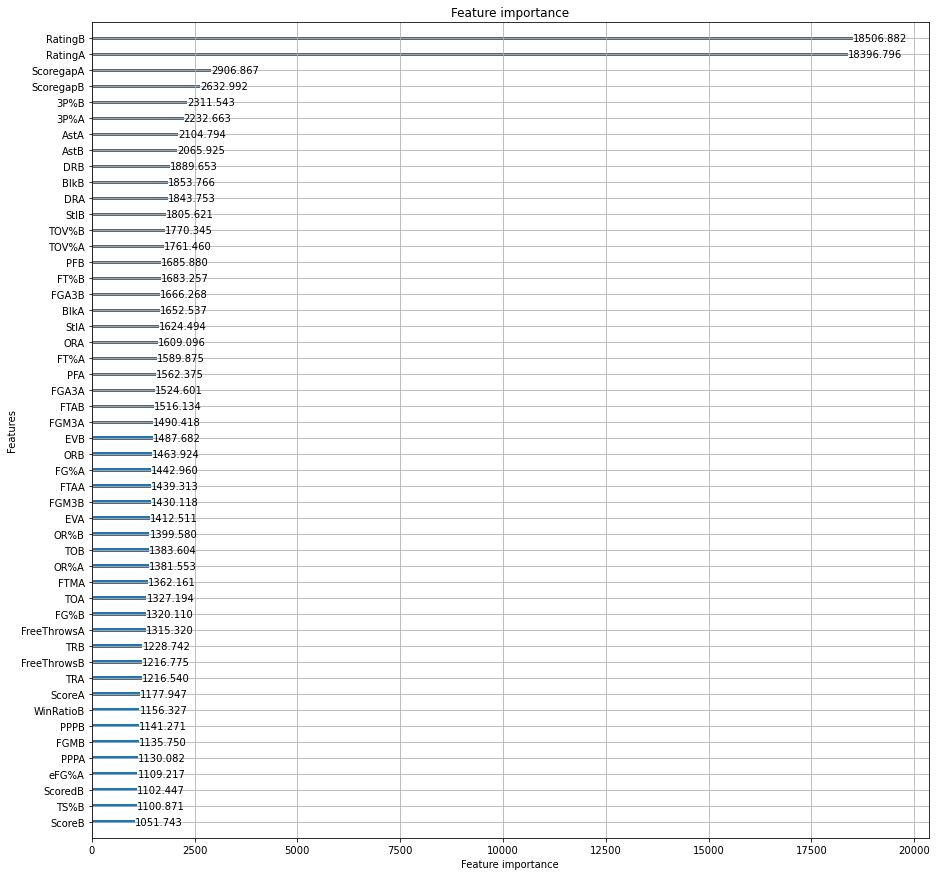

In [253]:
fig,ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
plt.show()

In [ ]:
#Hello